# No budget to fine-tune? Let's do Inference-Time Scaling!

In this exercise we will learn **inference-time scaling** using the **same LLM** (no training/no weight changes).

We will:
- Compare **Baseline vs CoT first**
- Then show **Majority vote over CoT**
- Then compare **Baseline vs ToT**


In [ ]:
import re
import time
import random
import textwrap

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import Optional, List, Dict, Tuple

from transformers import AutoTokenizer, AutoModelForCausalLM


# pretty printing helpers

def _wrap_block(text: str, width: int = 88) -> str:
    parts = []
    for p in text.split("\n"):
        p = p.rstrip()
        if not p:
            parts.append("")
        else:
            parts.append(textwrap.fill(p, width=width))
    return "\n".join(parts)


def pretty_print_section(title: str, body: str = "", width: int = 88) -> None:
    line = "=" * width
    print(line)
    print(textwrap.fill(title, width=width))
    if body:
        print("-")
        print(_wrap_block(body, width=width))
    print(line)


def pretty_print_kv(d: Dict, width: int = 88) -> None:
    for k, v in d.items():
        k = str(k)
        v = "None" if v is None else str(v)
        prefix = f"{k}: "
        wrapped = textwrap.fill(
            v,
            width=width,
            initial_indent=prefix,
            subsequent_indent=" " * len(prefix),
        )
        print(wrapped)


device = "cuda" if torch.cuda.is_available() else "cpu"
device

In [ ]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


seed_everything(42)
pretty_print_section("Random seed fixed", "seed=42")

## We load an instruction-tuned model

- **Qwen2.5-1.5B-Instruct** is our Guy


In [ ]:
MODEL_NAME = "Qwen/Qwen2.5-1.5B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16 if device == "cuda" else torch.float32,
    device_map="auto" if device == "cuda" else None,
)
model.eval()

pretty_print_section(
    "Model loaded",
    f"Name: {MODEL_NAME}\nDevice: {model.device}",
)


## Our confusing math questions

- We use a few arithmetic word problems with **unambiguous answers**.
- This makes it easy to measure improvements from Baseline → CoT → Voting → ToT.


In [ ]:
DATA = [
    {
        "id": "p1",
        "q": (
            "John starts the day with 12 apples in his bag. On the way to school, he gives Mary 5 apples. "
            "Later he remembers he still owes her something, but instead he goes to a shop and buys 7 more apples. "
            "Ignoring everything else that happened during the day, how many apples does John have in the end?"
        ),
        "a": "14",
    },
    {
        "id": "p2",
        "q": (
            "A store tracks sales poorly. In the morning it sells 18 notebooks, and in the afternoon it sells 27 more. "
            "At the end of the day, 9 notebooks are returned (meaning those should not count as sold anymore). "
            "So after fixing the messy bookkeeping, how many notebooks were actually sold in total?"
        ),
        "a": "36",
    },
    {
        "id": "p3",
        "q": (
            "A recipe says: '3 cups of flour per cake'. You decide to bake 5 cakes. "
            "You check your kitchen and find exactly 4 cups of flour already available. "
            "If you want to follow the recipe exactly, how many additional cups of flour must you get?"
        ),
        "a": "11",
    },
    {
        "id": "p4",
        "q": (
            "A bus begins with 25 passengers on board. At the first stop, 7 people leave the bus, "
            "then 12 different people enter. At the next stop, 5 more leave, and 3 enter. "
            "After all of that back-and-forth, what is the final number of passengers on the bus?"
        ),
        "a": "28",
    }
]



df = pd.DataFrame(DATA)

pretty_print_section(
    "Dataset loaded",
    f"Number of problems: {len(df)}\nColumns: {list(df.columns)}",
)

df

## Some functions we will need

These are mainly for:
- prompting
- text generation
- extracting the final integer answer
- scoring exact match

#### Try to understand `generate_text` and `make_prompt()`, we will use them later

In [ ]:
@dataclass
class GenResult:
    text: str
    new_tokens: int
    elapsed_s: float

def make_prompt(system: str, question: str) -> str:
    return f"{system}\n\nQuestion: {question}\nAnswer:"


@torch.no_grad()
def generate_text(
    prompt: str,
    max_new_tokens: int,
    temperature: float,
    do_sample: Optional[bool] = None,
) -> GenResult:
    if do_sample is None:
        do_sample = temperature > 0

    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"].to(model.device)
    attn_mask = inputs.get("attention_mask", None)
    if attn_mask is not None:
        attn_mask = attn_mask.to(model.device)

    t0 = time.time()
    out = model.generate(
        input_ids=input_ids,
        attention_mask=attn_mask,
        max_new_tokens=max_new_tokens,
        do_sample=do_sample,
        temperature=temperature if do_sample else None,
        pad_token_id=tokenizer.eos_token_id,
    )
    elapsed = time.time() - t0

    new_tokens = int(out.shape[1] - input_ids.shape[1])
    text = tokenizer.decode(out[0], skip_special_tokens=True)
    return GenResult(text=text, new_tokens=new_tokens, elapsed_s=elapsed)


def extract_int_answer(text: str) -> Optional[str]:
    m = re.search(r"Final\s*:\s*(-?\d+)", text)
    if m:
        return m.group(1)

    ints = re.findall(r"-?\d+", text)
    if not ints:
        return None
    return ints[-1]


def exact_match(pred: Optional[str], gold: str) -> bool:
    return (pred is not None) and (pred.strip() == str(gold).strip())

## 1. Baseline Vs. CoT
- The picture below depicts Chain of Thought, It is quite easy to implement
- Tasks:
    - Task 1: Write a good prompt that will force the model to think step by step
    - Task 2: Use `make_prompt` to create your prompt for both `run_baseline()` and `run_cot()`
    - Task 2: Use `generate_text()` to get your result for both `run_baseline()` and `run_cot()`

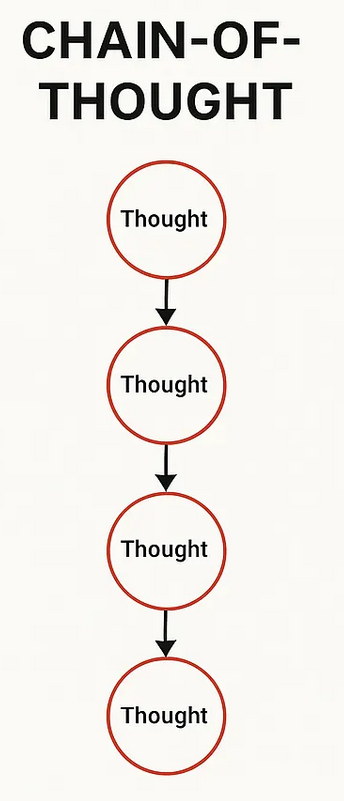


In [ ]:
SYSTEM_BASELINE = "You are a solver. Answer with only the final integer."

SYSTEM_COT = (
    # --- Task 1 begins here ---
    "NOT YET IMPLEMENTED"
    # --- Task 1 ends here ---
    "At the end output the final answer as: Final: <integer>."
)


def run_baseline(question: str) -> Dict:
    # --- Task 2 starts here ---
    prompt = "NOT YET IMPLEMENTED"
    # --- Task 2 ends here ---
    
    # --- Task 3 starts here ---
    res = "NOT YET IMPLEMENTED"
    # --- Task 3 ends here ---
    
    pred = extract_int_answer(res.text)
    return {
        "pred": pred,
        "tokens": res.new_tokens,
        "time_s": res.elapsed_s,
        "full_text": res.text,
    }


def run_cot(question: str) -> Dict:
    # ---  Task 2 starts here ---
    prompt = "NOT YET IMPLEMENTED"
    # --- Task 2 ends here ---
    
    # --- Task 3 starts here ---
    res = "NOT YET IMPLEMENTED"
    # --- Task 3 ends here ---
    
    pred = extract_int_answer(res.text)
    return {
        "pred": pred,
        "tokens": res.new_tokens,
        "time_s": res.elapsed_s,
        "full_text": res.text,
    }


example = df.iloc[0]
q, gold = example["q"], example["a"]




# --- Don't change this part ---

pretty_print_section(
    "Baseline vs CoT (single example)",
    f"Problem id: {example['id']}\nGold: {gold}",
)

print(textwrap.fill(f"Question: {q}", width=88))
print()

b = run_baseline(q)
pretty_print_section("[BASELINE]", f"Pred: {b['pred']} | Correct: {exact_match(b['pred'], gold)}")
pretty_print_kv(
    {
        "Tokens": b["tokens"],
        "Time_s": round(b["time_s"], 3),
    },
    width=88,
)
print("\nFull model output:\n")
print(textwrap.fill(b["full_text"], width=88))

print("\n" + "=" * 88 + "\n")

c = run_cot(q)
pretty_print_section("[CoT]", f"Pred: {c['pred']} | Correct: {exact_match(c['pred'], gold)}")
pretty_print_kv(
    {
        "Tokens": c["tokens"],
        "Time_s": round(c["time_s"], 3),
    },
    width=88,
)
print("\nFull model output (shows reasoning):\n")
print(_wrap_block(c["full_text"], width=88))

## 2. CoT + Majority Voting

Idea:
- Sample multiple different **CoT reasonings** (temperature > 0)
- Extract each final answer
- Pick the most common one (**majority vote**)

This is useful because sometimes the model makes a mistake in one reasoning path, but gets it right in most of them.
- Tasks:
    - Task 1: use `generate_text` to get your samples
    - Task 2: get the prediction for each sample
    - Task 3: update your counts
    - Task 4: Now get the majority vote (if there is a tie, pick a random one :D)


In [ ]:
def cot_majority_vote(question: str, n: int = 5) -> Dict:
    prompt = make_prompt(SYSTEM_COT, question)
    samples = []
    total_tokens = 0
    total_time = 0.0

    for _ in range(n):
        # --- Task 1 starts here ---
        res = "NOT YET IMPLEMENTED"
        # --- Task 1 ends here ---
        
        total_tokens += res.new_tokens
        total_time += res.elapsed_s
        samples.append(
            {
                "pred": extract_int_answer(res.text),
                "full_text": res.text,
            }
        )

    # majority vote
    counts = {}
    for sample in samples:
        # --- Task 2 starts here ---
        prediction = "NOT YET IMPLEMENTED"
        # --- Task 2 ends here ---
        if prediction is None:
            continue
        # --- Task 3 starts here ---
        counts[prediction] = "NOT YET IMPLEMENTED"
        # --- Task 3 ends here ---
        
    if not counts:
        vote = None
    else:
        # --- Task 4 starts here ---
        vote = "NOT YET IMPLEMENTED"
        # --- Task 4 ends here ---
        
    return {
        "vote": vote,
        "counts": counts,
        "samples": samples,
        "tokens": total_tokens,
        "time_s": total_time,
    }



# --- Don't change this part ---
example = df.iloc[0]
q, gold = example["q"], example["a"]

vote = cot_majority_vote(q, n=5)

pretty_print_section(
    "CoT Majority Vote (Self-Consistency)",
    f"Problem id: {example['id']}\nGold: {gold}\nSamples: 5",
)
print(textwrap.fill(f"Question: {q}", width=88))
print()

preds = [s["pred"] for s in vote["samples"]]
pretty_print_kv(
    {
        "Sampled predictions": preds,
        "Vote counts": vote["counts"],
        "Majority vote": f"{vote['vote']} | Correct: {exact_match(vote['vote'], gold)}",
        "Tokens": vote["tokens"],
        "Time_s": round(vote["time_s"], 3),
    },
    width=88,
)


## 3. Tree of Thought (ToT)

- Instead of one reasoning path, we ask the model for **multiple candidate arithmetic expressions** (as shown in picture below)
- We **evaluate them programmatically**.
- We pick the best expression that produces a valid integer answer.

- Tasks:
    - 

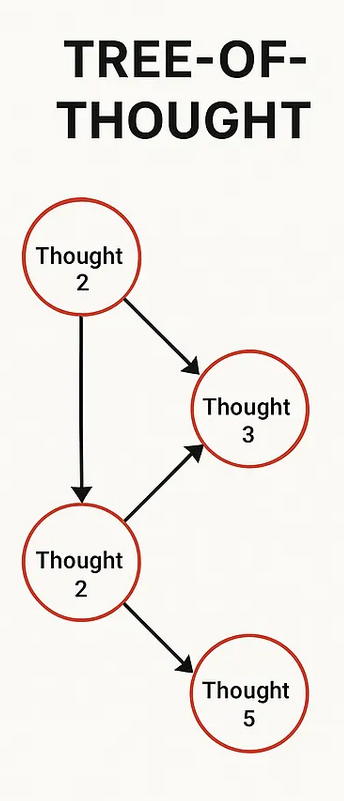

In [ ]:
SYSTEM_TOT = (
    "You are a solver. Produce one simple arithmetic expression using only + and - and integers. "
    "No words. No explanation."
)

SAFE_EXPR_RE = re.compile(r"^[0-9\s\+\-\(\)]+$")


def safe_eval(expr: str) -> Optional[int]:
    expr = expr.strip()
    if not expr:
        return None
    if not SAFE_EXPR_RE.match(expr):
        return None
    try:
        val = eval(expr, {"__builtins__": {}}, {})
        if isinstance(val, int):
            return val
        if isinstance(val, float) and float(val).is_integer():
            return int(val)
        return None
    except Exception:
        return None


def tot_one_step(question: str, k: int = 6) -> Dict:
    prompt = make_prompt(SYSTEM_TOT, question)
    candidates = []
    total_tokens = 0
    total_time = 0.0

    for _ in range(k):
        res = generate_text(prompt, max_new_tokens=20, temperature=0.9, do_sample=True)
        total_tokens += res.new_tokens
        total_time += res.elapsed_s

        tail = res.text.split("Answer:")[-1].strip()
        expr = tail.splitlines()[0].strip().replace("```", "")
        val = safe_eval(expr)
        candidates.append(
            {
                "expr": expr,
                "value": val,
                "valid": val is not None,
            }
        )

    # pick first valid candidate (simple heuristic)
    best = None
    for c in candidates:
        if c["valid"]:
            best = c
            break

    pred = str(best["value"]) if best else None
    return {
        "pred": pred,
        "best": best,
        "candidates": candidates,
        "tokens": total_tokens,
        "time_s": total_time,
    }



# --- Don't change this part ---
example = df.iloc[0]
q, gold = example["q"], example["a"]

b = run_baseline(q)
tot = tot_one_step(q, k=6)

pretty_print_section(
    "Baseline vs ToT (one-step branching)",
    f"Problem id: {example['id']}\nGold: {gold}\nBranches: 6",
)

print(textwrap.fill(f"Question: {q}", width=88))
print()

pretty_print_kv(
    {
        "BASELINE": f"Pred: {b['pred']} | Correct: {exact_match(b['pred'], gold)}",
        "ToT": f"Pred: {tot['pred']} | Correct: {exact_match(tot['pred'], gold)}",
        "ToT tokens": tot["tokens"],
        "ToT time_s": round(tot["time_s"], 3),
    },
    width=88,
)

print("\n" + "-" * 88)
print("ToT candidate branches:")
for i, c in enumerate(tot["candidates"], 1):
    line = f"{i:02d}. expr={c['expr']!r} | valid={c['valid']} | value={c['value']}"
    print(textwrap.fill(line, width=88, subsequent_indent=" " * 4))
print("-" * 88)
print(textwrap.fill(f"Chosen best: {tot['best']}", width=88))


---

# Just Evaluation, No Coding

---

## 4. Small evaluation: Baseline vs CoT vs Majority-Vote CoT vs ToT

We run all methods over the dataset and show:
- Accuracy
- Average generated tokens

We want to answer this question: does adding more compute at inference time give us a higher accuracy?

In [ ]:
def evaluate_all(df: pd.DataFrame) -> pd.DataFrame:
    rows = []

    for _, r in df.iterrows():
        q, gold = r["q"], r["a"]

        base = run_baseline(q)
        rows.append(
            {
                "method": "baseline",
                "id": r["id"],
                "pred": base["pred"],
                "gold": gold,
                "correct": exact_match(base["pred"], gold),
                "tokens": base["tokens"],
            }
        )

        cot = run_cot(q)
        rows.append(
            {
                "method": "cot",
                "id": r["id"],
                "pred": cot["pred"],
                "gold": gold,
                "correct": exact_match(cot["pred"], gold),
                "tokens": cot["tokens"],
            }
        )

        vote = cot_majority_vote(q, n=5)
        rows.append(
            {
                "method": "cot_vote(n=5)",
                "id": r["id"],
                "pred": vote["vote"],
                "gold": gold,
                "correct": exact_match(vote["vote"], gold),
                "tokens": vote["tokens"],
            }
        )

        tot = tot_one_step(q, k=6)
        rows.append(
            {
                "method": "tot(k=6)",
                "id": r["id"],
                "pred": tot["pred"],
                "gold": gold,
                "correct": exact_match(tot["pred"], gold),
                "tokens": tot["tokens"],
            }
        )

    return pd.DataFrame(rows)


pretty_print_section("Running full evaluation", "Methods: baseline | cot | cot_vote(n=5) | tot(k=6)")
results = evaluate_all(df)
results

In [ ]:
summary = (
    results.groupby("method", as_index=False)
    .agg(
        accuracy=("correct", "mean"),
        avg_tokens=("tokens", "mean"),
    )
    .sort_values("avg_tokens")
)

pretty_print_section("Summary table", "Accuracy + Avg generated tokens")
summary

## Plot: accuracy vs compute

We will compute proxy = average generated tokens.


In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(summary["avg_tokens"], summary["accuracy"], marker="o")

for _, row in summary.iterrows():
    label = row["method"]
    plt.text(row["avg_tokens"], row["accuracy"] + 0.01, textwrap.fill(label, width=18), fontsize=9)

plt.xlabel("Average generated tokens (compute proxy)")
plt.ylabel("Accuracy")
plt.title("Inference-Time Scaling: Baseline → CoT → Voting → ToT")
plt.grid(True)
plt.ylim(0, 1.05)
plt.show()